In [22]:
import json
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import Polygon, LineString
from shapely.ops import split
import numpy as np

In [3]:
with open('test.json') as in_file:
    asterism = json.load(in_file)

In [53]:
nodes = asterism['constellation']['arena']
root_node = nodes[0]
bounds = root_node['star']['constraints']['halfspaces']['bounds']['data']['data']
parents = asterism['constellation']['parents']

cons_coeffs = [node['star']['constraints']['halfspaces']['coeffs'] for node in nodes]
cons_coeffs = [np.reshape(node['data'], node['dim']) for node in cons_coeffs]
cons_rhs = [node['star']['constraints']['halfspaces']['rhs'] for node in nodes]
cons_rhs = [np.reshape(node['data'], node['dim']) for node in cons_rhs]

def check_ineq(i, point):
    ineq_test = np.matmul(cons_coeffs[i], point) <= cons_rhs[i]
    return np.all(ineq_test)    

In [56]:
boxes = []

bounds_box = Polygon([(bounds[0], bounds[1]), (bounds[2], bounds[1]), (bounds[2], bounds[3]),
                  (bounds[0], bounds[3]), (bounds[0], bounds[1])])
boxes.append(bounds_box)

for i, parent in enumerate(parents):
    if parent is None:
        continue

    if np.all(cons_coeffs[i][-1] == 0.) and cons_rhs[i][-1] == 0.:
        line = None
    elif np.all(cons_coeffs[i][-1] == 0.):
        print('Reached contradictory polygon')
        line = None
    elif cons_coeffs[i][-1][1] == 0.:
        x = cons_rhs[i][-1] / cons_coeffs[i][-1][0]
        line = LineString([(x, bounds[1]), (x, bounds[3])])
    else:
        slope = -cons_coeffs[i][-1][0] / cons_coeffs[i][-1][1]
        intercept = cons_rhs[i][-1] / cons_coeffs[i][-1][1]
        left = (bounds[0], slope * bounds[0] + intercept)
        right = (bounds[2], slope * bounds[2] + intercept)
        line = LineString([left, right])

    if line:
        parent_poly = boxes[parent]
        child_polys = split(parent_poly, line)
        for geom in child_polys.geoms:
            if check_ineq(i, np.array([geom.centroid.x, geom.centroid.y])):
                boxes.append(geom)
                print('Found child geom ', i)
    else:
        boxes.append(boxes[parent])


Found child geom  2
Found child geom  3


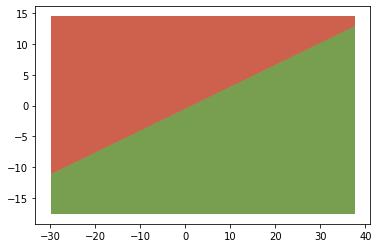

In [57]:
fig, axs = plt.subplots()
for geom in boxes:
    xs, ys = geom.exterior.xy
    axs.fill(xs, ys, alpha=0.5, ec='none')

plt.show()